# image classification with PyTorch

## import libraries

In [1]:
# . . import libraries
import os
from glob import glob
from pathlib import Path
from collections import Counter
# . . pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# . . PILLOW
from PIL import Image

# . . numpy
import numpy as np

# . . scikit-learn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# . . matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as npimg
# . .  set this to be able to see the figure axis labels in a dark theme
from matplotlib import style
#style.use('dark_background')
# . . to see the available options
# print(plt.style.available)

from torchsummary import summary

# . . import libraries by tugrulkonuk
import utils
#from dataset import Dataset
from model import *
from trainer import Trainer
from callbacks import ReturnBestModel, EarlyStopping


# set device and precision

In [2]:
# . . set the device
if torch.cuda.is_available():  
    device = torch.device("cuda")  
else:  
    device = torch.device("cpu")      

#device = torch.device("cpu")      
# . . set the default tensor to cuda: DO NOT USE THIS
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
# . . set the default precision
dtype = torch.float32

# . . use cudnn backend for performance
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [3]:
# . . arguments . .
# . . this is only for the Jupyter notebook as there is no command line
class Args():
    # . . number of epochs 
    epochs = 10
    
    # . . the learning rate 
    lr = 0.003

    # . . batch_size
    batch_size = 64

    # . . fraction of data to be used in training
    train_size = 0.8

    # . . min delta (min improvement) for early stopping
    min_delta = 0.003

    # . . patience for early stopping
    patience = 20

    # . . number of workers for the data loader
    num_workers = 8

    # . . use pinn memory for faster CPU-GPU transler
    pin_memory = False

    # . . print interval
    jprint = 1



In [4]:
# . . instantiate the command-line parameters object
args = Args()

# . . get command-line parameters
num_epochs    = args.epochs
batch_size    = args.batch_size
learning_rate = args.lr
train_size    = args.train_size
min_delta     = args.min_delta
patience      = args.patience 
num_workers   = args.num_workers
pin_memory    = args.pin_memory
jprint        = args.jprint

## download the dataset: The Yale Face Dataset


In [5]:
# . . data if from :http://visian.ucsd.edu/content/yale-face-dataset
# . . download the data: uncomment to run
#!wget -nc http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip

# . . unzip the data archive: uncomment to run
#!unzip yalefaces.zip

In [6]:
# . . get the file paths
files = glob('yalefaces/subject*')

In [7]:
# . . shuffle the file paths
np.random.shuffle(files)

In [8]:
# . . the number of images
num_samples = len(files)
print('number of images: ', num_samples)

number of images:  166


In [9]:
# . . the height and width of images
width, height = 80, 60
# . . load, resize, and scale an image
def load_img(filepath, imsize=(80,60)):
    # . . load and downsample an image for training
    img = Image.open(filepath).resize(imsize)    

    # . . return a numpy array as 8-bit unisgned integer
    return np.array(img).astype('uint8') / 255.

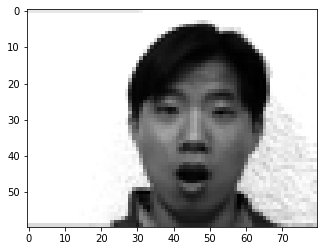

In [10]:
# display a random image
img = load_img(np.random.choice(files))
plt.imshow(img, cmap='gray')
plt.show()

In [11]:
# . . load iamges as numpy arrays
shape = (num_samples, height, width)
images = np.zeros(shape)
for i, imfile in enumerate(files):
    images[i] = load_img(imfile)

In [12]:
# . . make data labels
# . . file names contains subject numbers followed by descriptor. For example: subject23.happy
labels = np.zeros(num_samples)
for i, imfile in enumerate(files):
    # . . split the fifle name
    filename = imfile.rsplit('/',1)[-1]
    # . . split the subject name
    subject_num = filename.split('.',1)[0]

    # . .  remove the subject string and subtract one since the file names start from 1
    index = int(subject_num.replace('subject', '')) - 1
    # . . use the subject numbers as labels
    labels[i] = index

In [13]:
# . .  count labels for each subject to decide how many of each subject we have
label_count = Counter(labels)
print(label_count)

Counter({0.0: 12, 4.0: 11, 1.0: 11, 7.0: 11, 9.0: 11, 5.0: 11, 14.0: 11, 13.0: 11, 2.0: 11, 11.0: 11, 8.0: 11, 3.0: 11, 12.0: 11, 6.0: 11, 10.0: 11})


In [14]:
# . . get the unique labels
unique_labels = set(label_count.keys())

In [15]:
# . . get the number of subjects
num_subjects = len(label_count)

In [16]:
# . . use three images for each subjects as test dataset
# . . do here to prevent repeating the same images in both train and test sets
# . . when we create pair of images
num_valid = 3*num_subjects
num_train = num_samples - num_valid

In [17]:
# . . initialize arrays to hold train and test images
# . . training data
train_images = np.zeros([num_train] + list(img.shape))
train_labels = np.zeros(num_train)
# . . test data
valid_images = np.zeros([num_valid] + list(img.shape))
valid_labels = np.zeros(num_valid)

In [18]:
# . . prepare the train and test images
# . . loop through each images and assign the first three encountered images as test/validation dataset
# . .  and the remaining ones as training dataset
# . . number of images for each subkject we've been encountered so far
count_so_far = {}
# . . where to put image we encountered
train_idx = 0
valid_idx  = 0
# . . loop over images
for img, label in zip(images, labels):
    # . . increase the counter
    count_so_far[label] = count_so_far.get(label, 0) + 1

    # . . put into train set if we already put three images into the validation set for this subject 
    if count_so_far[label] > 3:
        train_images[train_idx] = img
        train_labels[train_idx] = label
        train_idx += 1

    # . . else, add the first threes images to the validation dataset
    else:
        valid_images[valid_idx] = img
        valid_labels[valid_idx] = label
        valid_idx += 1

In [19]:
# . . we do not want to store pairs of images. 
# . . this would cause unnecessary repetition of images on memory
# . . instead, we only save their indexes

# . . the key is the subkect ID and the value is a list containing 
# . . all the indexes showing whre the all the subject images are stored
train_labelToindex = {}
valid_labelToindex  = {}

# . . the training dataset
for i, label in enumerate(train_labels):
    if label not in train_labelToindex:
        train_labelToindex[label] = [i]
    else:
        train_labelToindex[label].append(i)

# . . the test dataset
for i, label in enumerate(valid_labels):
    if label not in valid_labelToindex:
        valid_labelToindex[label] = [i]
    else:
        valid_labelToindex[label].append(i)        

In [20]:
# . . calculate the all possible training sample indices
# . . indices for matches
train_positives = []
valid_positives = []
# . . incides for non-matches
train_negatives = []
valid_negatives = []

# . . the training data
for label, indices in train_labelToindex.items():
    # . . all indices that do not belong to this subject
    other_indices = set(range(num_train)) - set(indices)

    for i, idx1 in enumerate(indices):
        for idx2 in indices[i+1:]:
            train_positives.append((idx1, idx2))

        for idx2 in other_indices:
            train_negatives.append((idx1, idx2))

# . . the validation data
for label, indices in valid_labelToindex.items():
    # . . all indices that do not belong to this subject
    other_indices = set(range(num_valid)) - set(indices)

    for i, idx1 in enumerate(indices):
        for idx2 in indices[i+1:]:
            valid_positives.append((idx1, idx2))

        for idx2 in other_indices:
            valid_negatives.append((idx1, idx2))            

In [21]:
print(int(np.ceil(len(train_positives) / batch_size)))

7


## data loaders

In [22]:
# . . the sample generator function for the training
# . . sends a pair of each subject and the same number of non-matching pair images for each batch
def trainloader():
    num_batches = int(np.ceil(len(train_positives) / batch_size))

    while True:
        np.random.shuffle(train_positives)
        num_samples = batch_size * 2
        shape = (num_samples, height, width)
        x_batch_one = np.zeros(shape)
        x_batch_two = np.zeros(shape)
        y_batch = np.zeros(num_samples)
        
        for i in range(num_batches):
            # . . start with the positive indices
            positive_batch_indices = train_positives[i*batch_size: (i+1)*batch_size]

            # . . fill up the x_batch and y_batch
            j = 0
            for idx1, idx2 in positive_batch_indices:
                x_batch_one[j] = train_images[idx1]
                x_batch_two[j] = train_images[idx2]
                y_batch[j] = 1 # . . it is a match
                j += 1

            # . . continue with the negative indices
            # . . randomly select no-matched images with the same size of matched images
            negative_batch_indices = np.random.choice(len(train_negatives), size=len(positive_batch_indices), replace=False)
            for k in negative_batch_indices:
                idx1, idx2 = train_negatives[k]
                x_batch_one[j] = train_images[idx1]
                x_batch_two[j] = train_images[idx2]
                y_batch[j] = 0 # . . it is not a match

            x1 = x_batch_one[:j]
            x2 = x_batch_two[:j]
            y = y_batch[:j]

            # . . reshape arrays
            x1 = x1.reshape(-1, 1, height, width)
            x2 = x2.reshape(-1, 1, height, width)

            # . . convert to torch tensor
            x1 = torch.from_numpy(x1.astype(np.float32))
            x2 = torch.from_numpy(x2.astype(np.float32))
            y  = torch.from_numpy(y.astype(np.float32))

            yield [x1, x2], y


In [23]:
# . . the sample generator function for the validation dataset: No shuffling
# . . sends a pair of each subject and the same number of non-matching pair images for each batch
def validloader():
    num_batches = int(np.ceil(len(valid_positives) / batch_size))
    print('num_batches: ',num_batches)

    while True:
        num_samples = batch_size * 2
        shape = (num_samples, height, width)
        x_batch_one = np.zeros(shape)
        x_batch_two = np.zeros(shape)
        y_batch = np.zeros(num_samples)

        for i in range(num_batches):
            # . . start with the positive indices
            positive_batch_indices = valid_positives[i*batch_size: (i+1)*batch_size]

            # . . fill up the x_batch and y_batch
            j = 0
            for idx1, idx2 in positive_batch_indices:
                x_batch_one[j] = valid_images[idx1]
                x_batch_two[j] = valid_images[idx2]
                y_batch[j] = 1 # . . it is a match
                j += 1

            # . . continue with the negative indices
            # . . randomly select no-matched images with the same size of matched images
            negative_batch_indices = np.random.choice(len(valid_negatives), size=len(positive_batch_indices), replace=False)
            for k in negative_batch_indices:
                idx1, idx2 = valid_negatives[k]
                x_batch_one[j] = valid_images[idx1]
                x_batch_two[j] = valid_images[idx2]
                y_batch[j] = 0 # . . it is not a match

            x1 = x_batch_one[:j]
            x2 = x_batch_two[:j]
            y = y_batch[:j]

            # . . reshape arrays
            x1 = x1.reshape(-1, 1, height, width)
            x2 = x2.reshape(-1, 1, height, width)

            # . . convert to torch tensor
            x1 = torch.from_numpy(x1.astype(np.float32))
            x2 = torch.from_numpy(x2.astype(np.float32))
            y  = torch.from_numpy(y.astype(np.float32))

            yield [x1, x2], y


In [24]:
# . . instantiate the model
model = SiameseNetwork(50, device=device)

# . . send model to device (GPU)
#model.to(device)

In [25]:
# . . the loss function for the siamese network
def contrastive_loss(y, t):
  nonmatch = F.relu(1 - y) # . . max(margin - y, 0)
  return torch.mean(t * y**2 + (1 - t) * nonmatch**2)

In [26]:
# . . create the trainer
trainer = Trainer(model, device)

# . . compile the trainer
# . . define the loss
criterion = contrastive_loss

# . . define the optimizer
optimparams = {'lr':learning_rate
              }

# . . define the callbacks
cb=[ReturnBestModel(), EarlyStopping(min_delta=min_delta, patience=patience)]

trainer.compile(optimizer='adam', criterion=criterion, callbacks=cb, jprint=jprint, **optimparams)

# . . the learning-rate scheduler
schedulerparams = {'factor':0.5,
                   'patience':3,
                   'threshold':1e-3,
                   'cooldown':5,
                   'min_lr':1e-5,                
                   'verbose':True               
                  }
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(trainer.optimizer, **schedulerparams)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [27]:
# . . train the network
# . . the number of training and test steps per epoch
num_train_steps = int(np.ceil(len(train_positives) / batch_size))
num_valid_steps = int(np.ceil(len(valid_positives) / batch_size))

print("number of training steps per epoch: ", num_train_steps)
print("number of validation steps per epoch: ", num_valid_steps)

# . . the model training
train_loss, valid_loss = trainer.fit(trainloader(), 
                                     validloader(), 
                                     scheduler=scheduler, 
                                     num_epochs=num_epochs, 
                                     num_train_steps=num_train_steps, 
                                     num_valid_steps=num_valid_steps)

number of training steps per epoch:  7
number of validation steps per epoch:  1
Training started:  February 12, 2021 - 09:14PM
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
num_batches:  1
Epoch:     0	Train Loss: 20.039214	Valid Loss: 0.717353	Elapsed time: 0:00:00.380358
Epoch:     1	Train Loss: 3.948953	Valid Loss: 1.371517	Elapsed time: 0:00:00.114816
Epoch:     2	Train Loss: 1.208825	Valid Loss: 0.342496	Elapsed time: 0:00:00.110985
Epoch:     3	Train Loss: 0.456348	Valid Loss: 0.135608	Elapsed time: 0:00:00.109271
Epoch:     4	Train Loss: 0.214782	Valid Loss: 0.073880	Elapsed time: 0:00:00.118642
Epoch:     5	Train Loss: 0.108333	Valid

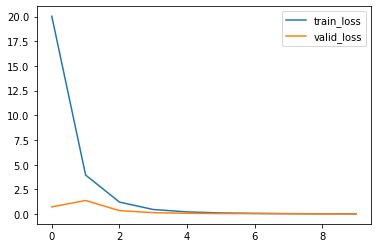

In [28]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train_loss', 'valid_loss'])

In [29]:
# . . compute the training accuracy
train_positive_distances, train_negative_distances = utils.accuracy(model, 
                                                                    train_images, 
                                                                    train_positives, 
                                                                    train_negatives, 
                                                                    batch_size,
                                                                    width,
                                                                    height,
                                                                    threshold=0.2)

positive batch: 1/7
positive batch: 2/7
positive batch: 3/7
positive batch: 4/7
positive batch: 5/7
positive batch: 6/7
positive batch: 7/7
negative batch: 1/7
negative batch: 2/7
negative batch: 3/7
negative batch: 4/7
negative batch: 5/7
negative batch: 6/7
negative batch: 7/7
Sensitivity (TPr): 0.9742990654205608 Specificity (TNr): 0.9910714285714286


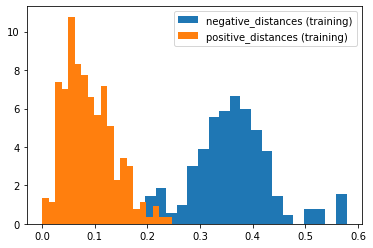

In [30]:
# . . plot distances between matching images
plt.hist(train_negative_distances, bins=20, density=True, label='negative_distances (training)')
plt.hist(train_positive_distances, bins=20, density=True, label='positive_distances (training)')
plt.legend()
plt.show()

In [34]:
# . . compute the validation accuracy
valid_positive_distances, valid_negative_distances = utils.accuracy(model, 
                                                                    valid_images, 
                                                                    valid_positives, 
                                                                    valid_negatives, 
                                                                    batch_size,
                                                                    width,
                                                                    height,
                                                                    threshold=0.2)

positive batch: 1/1
negative batch: 1/1
Sensitivity (TPr): 0.9555555555555556 Specificity (TNr): 0.75


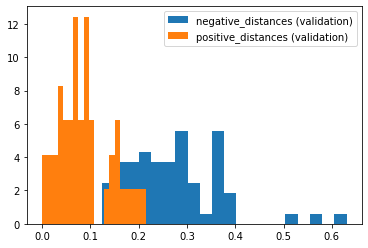

In [35]:
# . . plot distances between matching images
plt.hist(valid_negative_distances, bins=20, density=True, label='negative_distances (validation)')
plt.hist(valid_positive_distances, bins=20, density=True, label='positive_distances (validation)')
plt.legend()
plt.show()